In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. (20/100 points) Take multiple pictures (at least 10) of the environment while the robot is rotating, and store them in an array. For each image, capture the robot orientation.

# Get images from visual sensor

In [2]:
import sim as vrep
import time
import cv2
import numpy as np

vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

# This stores each image and its orientation
image_data = []

if clientID!=-1:
    # Handler for the camera, and other items
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    res, pion = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx', vrep.simx_opmode_oneshot_wait)
    res, sphe = vrep.simxGetObjectHandle(clientID, 'Sphere', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 20
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_oneshot_wait)
        # Get the orientation (the orientation is relative to a sphere, which likely isn't necessary)
        err, orient = vrep.simxGetObjectOrientation(clientID, pion, sphe, vrep.simx_opmode_streaming)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            image_data.append((img, pi - orient[2]))
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!
image 12 OK!!!
image 13 OK!!!
image 14 OK!!!
image 15 OK!!!
image 16 OK!!!
image 17 OK!!!
image 18 OK!!!
image 19 OK!!!


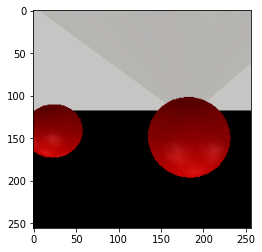

In [3]:
# Only shows the last image
imshow(img)

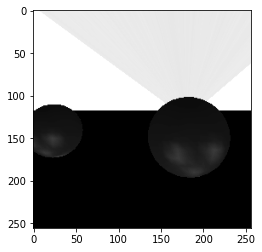

In [4]:
# This is for the gray scale version of each image, and its orientation
gray_imgs = []
# Convert each image to gray scale
for image, orient in image_data:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imshow(gray, cmap='gray')
    gray_imgs.append((gray, orient))

# 2. (20/100 points) Use the Hough algorithm to detect circles in each image. If there are multiple circles, you can either use all the circles if you want or use the largest only

In [5]:
# This is an array of tuples containing an array of circle information and the orientation for the image that was used to find those circles
circle_data = []
for image, orient in gray_imgs:
    gray = cv2.medianBlur(image,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=60)
    circle_data.append((circles, orient))
print(circle_data)

[(array([[[121.5, 148.5,  46.1]]], dtype=float32), 1.616735966997691), (array([[[ 40.5, 146.5,  52.9],
        [239.5, 142.5,  30.6]]], dtype=float32), 1.9424995501809796), (array([[[161.5, 138.5,  26.1]]], dtype=float32), 2.2595042904191693), (array([[[ 90.5, 139.5,  26.1]]], dtype=float32), 2.5821889360719403), (array([[[183.5, 151.5,  55.6],
        [ 15.5, 140.5,  26.4]]], dtype=float32), 2.9045703579955777), (array([[[106.5, 153.5,  52.3],
        [243.5, 136.5,  36.9]]], dtype=float32), 3.2335003336244306), (array([[[165.5, 139.5,  29.7]]], dtype=float32), 3.5464548786454877), (array([[[ 94.5, 139.5,  29.5]]], dtype=float32), 3.8595277984910688), (array([[[199.5, 137.5,  22.9],
        [ 19.5, 142.5,  30.1]]], dtype=float32), 4.184086473780223), (array([[[124.5, 138.5,  21.6]]], dtype=float32), 4.509819897013255), (array([[[ 59.5, 137.5,  22.9],
        [253.5, 146.5,  45.5],
        [111.5,  82.5,  34.3]]], dtype=float32), 4.7924988587671), (array([[[187.5, 143.5,  42.4]]], dtyp

# 3. (20/100 points) Based on the robot’s orientation at each picture, map the field of view and the detected spheres to the world frame

In [6]:
# The photo is 256x256
u0, v0 = 128, 128

fov = 60  # degrees

# number of pixels in x-axis
npx = 256

# This contains the location of each sphere according to the world frame
spheres_data = []

for circles, orient in circle_data:
    sphere_data = []
    if circles is not None:
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2] # In pixels

            k = radius / 0.75  # Pixels per meters (radius in pixels / radius in  meters)

            # maximum value in the x-axis (in meters)
            xmax = npx / (2.* k)

            # Distance to the center of the sphere (z-axis coordinate)
            zc = xmax / tan(pi/6)

            # Location of the sphere in the x-axis coordinate
            xc = (center[0] - u0) / k

            # This converts the xc, zc values to be in the world frame of reference. 
            zc_z = cos(orient) * zc
            zc_x = sin(orient) * zc

            xc_z = -sin(orient) * xc
            xc_x = cos(orient) * xc

            sphere_data.append((zc_x + xc_x, zc_z + xc_z))
    spheres_data.append((sphere_data, orient))
spheres_data

[([(3.6079247571473427, -0.06000340068309051)], 1.616735966997691),
 ([(3.3791498342478437, 0.014201043889052523),
   (4.070228814503742, -4.519820023812721)],
  1.9424995501809796),
 ([(4.306861094348924, -4.792101042517215)], 2.2595042904191693),
 ([(4.294173003415108, -4.8278227266322995)], 2.5821889360719403),
 ([(-0.02550148612847236, -3.0827690623686643),
   (4.585581253576685, -5.371818013419807)],
  2.9045703579955777),
 ([(0.015226145697377014, -3.19416879093528),
   (-2.7512197302677293, -4.271674634183841)],
  3.2335003336244306),
 ([(-3.075637445716645, -4.772938789439255)], 3.5464548786454877),
 ([(-3.0663993351614867, -4.805492724837633)], 3.8595277984910688),
 ([(-7.451440923914312, -1.637592761103619),
   (-3.40826619400947, -5.11945206421989)],
  4.184086473780223),
 ([(-7.516152207761234, -1.6677776099237194)], 4.509819897013255),
 ([(-7.417242852896127, -1.6551990988109244),
   (-3.4771721852094837, 2.354490352518543),
   (-4.861047160733924, 0.02830510630803673)],
 

### Grid representation

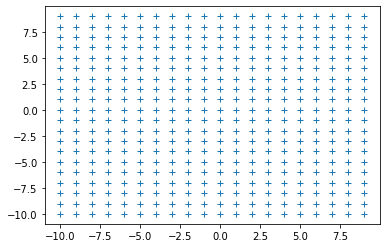

In [7]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

Draw each cell independently

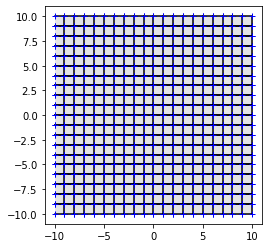

In [8]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

# 4. (60/100 points) Using occupancy grid and the log odds method, combine all the measurements in the grid map.

## Use the measurement

In [9]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# For each cell, check if the circle is in it.
for i in range(n*n):
    x, y = grid_x[i], grid_y[i]
    # Corners of the cell
    X, Y = points_cell(x, y, cell_w)
    # Check the spheres for each image
    for spheres, orient in spheres_data:
        sphere_found = False
        # Check each sphere location in each image
        for xc1, zc1 in spheres:
            # check based on the ecuclidean distance
            dist = sqrt((xc1 - X)**2 + (zc1 - Y)**2)

            # Check if At least one of the borders is within the sphere
            if((dist < 0.75).any()):
                sphere_found = True
                po = 0.95  # P(mi/zt) probability of having an obstacle 
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li  # P(mi/zt) 
        # If the location had no spheres intersecting with it
        if not sphere_found:
            po = 0.30  # P(mi/zt) probability of having an obstacle given a non-detected obstacle

            # Cells within the fov. Check if the four points are withing the FOV
            # This accounts for the robots orientation at the time of the photo
            thetas = abs(np.arctan2(Y,X) - pi/2 + orient) % (2 * pi)
            if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li

                pass

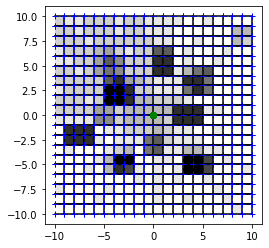

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()